In [9]:
# ============================
# Cell 1 — Paths & imports (robust)
# ============================
import sys, os, os.path as path, time, math, copy, warnings, json, csv, random
from pathlib import Path

# Try importing qae_utils; if it fails, add parent repo root
try:
    from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
    from qae_utils.Charts import multi_plot_flat_ts, meas_plot
    from qae_utils.Tools import draw_circuit
    from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
    from qae_utils.Window import ts_calc_noise, ts_add_noise
except ModuleNotFoundError:
    # search current dir, parent, and grandparent for a qae_utils folder
    CWD = Path.cwd().resolve()
    for root in (CWD, CWD.parent, CWD.parent.parent):
        if (root / "qae_utils").exists():
            sys.path.insert(0, str(root))
            break
    # try again (will raise if still not found)
    from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
    from qae_utils.Charts import multi_plot_flat_ts, meas_plot
    from qae_utils.Tools import draw_circuit
    from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
    from qae_utils.Window import ts_calc_noise, ts_add_noise

# PennyLane / plotting, etc.
import matplotlib.pyplot as plt
import pylab
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
import pandas as pd
from IPython.display import clear_output, display
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

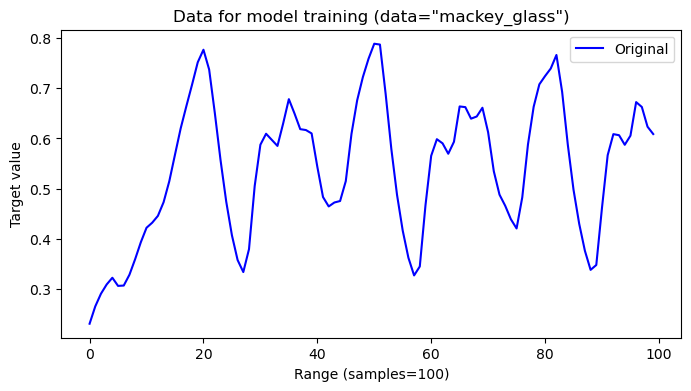

In [10]:
# =====================================
# Cell 2 — Constants & data load
# =====================================
LOG_NAME     = 'aintern'
DATA_NAME    = 'mackey_glass'
CASE_NAME    = 'full_qae'

DATA_PATH    = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH   = f'{LOG_NAME}/training'
PARAMS_PATH  = f'{LOG_NAME}/params'
ANALYSIS_PATH= f'{LOG_NAME}/analysis'

for p in (FIGURES_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH):
    create_folder_if_needed(p)

# Identify data to load
DATA_ID = 'mackey_glass_n100'

# Load repository info
data_info_path = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info = read_json_file(data_info_path)

# Pull data hyper-parameters
samples      = data_info['samples']
scale_margin = data_info['scale_margin']
scale_low    = data_info['scale_low']
scale_high   = data_info['scale_high']

# Data files (already 0..pi encoded in repo)
x_org_fpath = f'{DATA_PATH}/{DATA_ID}/x_org.arr'
y_org_fpath = f'{DATA_PATH}/{DATA_ID}/y_org.arr'

# Load the data set
X = read_ts_file(x_org_fpath).astype(int)
y = read_ts_file(y_org_fpath)

# Quick visual (optional)
X_list = [0]
y_list = [y]
multi_plot_flat_ts(
    [y], X_list=X_list,
    colors=['blue'], labels=['Original'],
    lines=['solid'], legend_cols=1, rcParams=(8, 4),
    xlabel=f'Range (samples={samples})',
    title=f'Data for model training (data="{DATA_NAME}")'
)

import numpy as onp  # plain NumPy as onp, PL-NumPy is `np` from pennylane

# --- same constants/seed functions as your stage-3 ---
VAL_BASE_SEED = 12345  # fixed per-window validation seed

def ts_add_noise_window_det(x, sigma, seed, low=None, high=None):
    """
    Deterministic Gaussian noise for one window, matching your stage-3.
    sigma is relative to (high-low).
    """
    if low is None:  low  = float(scale_low)
    if high is None: high = float(scale_high)
    rng = onp.random.default_rng(int(seed))
    x = onp.asarray(x, dtype=float)
    noise = rng.normal(0.0, sigma * (high - low), size=x.shape)
    return onp.clip(x + noise, low, high)

def make_train_seed(instance_id, layers, ep, k, view=0):
    # identical arithmetic as your stage-3 (linear hash, mod 2^31-1)
    return (1_000_003 * (int(instance_id) * 10 + int(layers)) + 97 * int(ep) + 31 * int(k) + int(view)) % 2_147_483_647

In [11]:
# ===========================================
# Cell 3 — Model & training helpers
# ===========================================

# Sliding windows tensors (overlapping by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, split=0.75):
    y_ts = ts_wind_make(ts_add_noise(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens  = np.tensor(X_test_ts,  requires_grad=False)
    y_test_tens  = np.tensor(y_test_ts,  requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

# Loss
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

# Entangler shape
def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    return shape

# Full-QAE circuit
def full_qae(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry', add_outseq=True, invert_dec=True):

    latent_wires = wires[0:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    extra_wires  = wires[n_latent+n_trash:]
    data_wires   = latent_wires + trash_wires
    anz_wires    = latent_wires + trash_wires + extra_wires

    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        for w in wires:
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)

    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    def _full_qae(weights, inputs):
        # Input encoder
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # Encoder/decoder shapes (symmetric)
        enc_weights_shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        dec_weights_shape = enc_weights_shape

        # Split flat weights into two halves: [encoder | decoder]
        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        # Encoder
        _entangler(anz_wires, enc_weights, rot=rot)

        # Reset trash & extra
        qml.Barrier(wires)
        for w in trash_wires: qml.measure(w, reset=True)
        for w in extra_wires: qml.measure(w, reset=True)
        qml.Barrier(wires)

        # Decoder (adjoint of dec_weights block)
        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)

        # Optional output de-encoder
        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)

        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]

    return _full_qae

# Training loop — now takes param_shape explicitly
def train_with_noise(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2,
                     seed=0,                      # used only for init/PL-NumPy ops
                     wind_size=8, wind_step=4, noise=0.0, weight_scaler=0.1,
                     param_shape=None, instance_id=1, n_layers=1):
    """
    Training loop, now with deterministic per-window, per-epoch noise.
    """
    # global reproducibility for PL-NumPy ops (not for noise itself)
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)

    # define cost
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    hist_cost, hist_params = [], []

    # init weights
    if init_weights is None:
        if param_shape is None:
            raise ValueError("train_with_noise: param_shape must be provided when init_weights is None.")
        init_weights = np.random.uniform(high=onp.pi, size=param_shape, requires_grad=True) * weight_scaler
    params = init_weights.copy()

    # pure training targets (no noise)
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0.0, wind_size=wind_size, wind_step=wind_step)

    # start clock
    if start_time == 0: start_time = time.time()

    for ep in range(n_epochs):
        # --- build deterministic noisy X for this epoch ---
        noisy_list = []
        for k in range(len(y_pure_tens)):
            seed_k = make_train_seed(instance_id, n_layers, ep, int(k))
            noisy_k = ts_add_noise_window_det(y_pure_tens[k], sigma=noise, seed=seed_k,
                                              low=float(scale_low), high=float(scale_high))
            noisy_list.append(noisy_k)
        X_noisy_tens = np.tensor(onp.stack(noisy_list, axis=0), requires_grad=False)

        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_pure_tens), params)
        elapsed_time = time.time() - start_time

        if ep % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (ep % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {ep:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')

    # summary
    min_cost = onp.min(onp.asarray(hist_cost)) if hist_cost else onp.nan
    min_iter = int(onp.argmin(onp.asarray(hist_cost))) if hist_cost else -1
    print(f'\nTraining completed: epochs={n_epochs}, min cost={onp.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, float(min_cost), float(elapsed_time))

In [ ]:
# =====================================================
# Cell 4 — Config (2L/2T), seeding, and CSV setup
# =====================================================
# Architecture for this notebook
n_latent = 2
n_trash  = 2
n_extra  = 0
n_qubits = n_latent + n_trash + n_extra  # 4
rot = "Rxyz"

# Fixed noise & windows
EVAL_SIGMA    = 0.10
WINDOW_STRIDE = 1
WIND_SIZE     = n_qubits
WIND_STEP     = WINDOW_STRIDE

# Training sweep: layers & instances
LAYERS_LIST  = [1, 3]
INSTANCE_IDS = [1, 2, 3, 4, 5]

# My seed generator
def set_global_seed(instance_id: int):
    """
    Derive all RNGs from a simple instance ID (1..5).
    Keep the mapping stable across notebooks.
    """
    base = 10_000 + int(instance_id)  # simple, memorable
    random.seed(base + 11)
    onp.random.seed(base + 22)
    try:
        np.random.seed(base + 33)
    except Exception:
        pass
    # Pennylane's default.qubit is deterministic given params; no device seeding needed.
    return dict(global_seed=base, numpy_seed=base+22, pnp_seed=base+33)

# Separate output base for THIS notebook (won't touch your other CSVs)
OUT_BASE = "runs_full_qae_2LT2"
Path(OUT_BASE).mkdir(parents=True, exist_ok=True)

# CSV v3 (paper-style)
CSV_SCHEMA_VERSION = "v3"
CSV_PATH = f"{OUT_BASE}/all_training_instances_{CSV_SCHEMA_VERSION}.csv"

CSV_HEADER = [
    # id / naming
    "filename","run_tag","dataset_folder","instance_id","rng_seed",
    # architecture
    "n_qubits","n_latent","n_trash","n_layers",
    # noise & window
    "sigma_train","sigma_eval","window_stride",
    # stage-1 placeholders
    "s1_lr_init","s1_max_epochs","s1_patience","s1_lr_patience",
    "s1_best_val","s1_final_val","s1_best_epoch","s1_epochs","s1_train_seconds",
    # stage-3 hyperparams + outcomes (monolith training)
    "s3_lr_init","s3_max_epochs","s3_patience","s3_plateau_steps","s3_plateau_factor",
    "s3_best_val_mse","s3_final_val_mse","s3_best_epoch","s3_epochs","s3_train_seconds",
    "s3_noisy_baseline_mse","s3_best_delta_pct","s3_final_delta_pct",
    # params
    "phi_params","psi_params",
    # totals
    "total_train_seconds",
]

def ensure_dir(p: str) -> str:
    Path(p).mkdir(parents=True, exist_ok=True)
    return p

def std_instance_name(n_qubits, n_latent, n_trash, L, inst):
    return f"{n_qubits}q_{n_latent}l_{n_trash}t_{L}ls_{inst:02d}.json"

def _ensure_csv(path, header):
    write_header = True
    if os.path.exists(path):
        try:
            with open(path, "r", encoding="utf-8") as f:
                write_header = (f.readline().rstrip("\n") != ",".join(header))
        except Exception:
            write_header = True
    if write_header:
        with open(path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(header)

_ensure_csv(CSV_PATH, CSV_HEADER)

# Label only (data repo)
data_folder = "MG_bench"

In [ ]:
# ====================================================
# Cell 5 — Saver (JSON bundle + CSV upsert)
# ====================================================
# Stage-1 placeholders (monolith has no S1/S3 split)
S1_LR_INIT       = 0.0
S1_MAX_EPOCHS    = 0
S1_PATIENCE      = 0
S1_LR_PATIENCE   = 0

# Stage-3 hyperparams (monolith training)
S3_LR_INIT       = 0.5     # Adam(stepsize)
S3_MAX_EPOCHS    = 120    # you can change this but match the one in the next cell
S3_PATIENCE      = 0
S3_PLATEAU_STEPS = 0
S3_PLATEAU_FACT  = 1.0

def save_monolith_run(*,
    L: int,
    inst_id: int,
    rng_seed: int,
    decoder_mode: str,
    scale_low: float,
    scale_high: float,
    full_params,
    hist_cost,
    train_seconds,
    train_baseline_mse=None,
):
    subroot = ensure_dir(f"{OUT_BASE}/q{n_qubits}_l{n_latent}t{n_trash}/L{L}")
    fname   = std_instance_name(n_qubits, n_latent, n_trash, L, inst_id)
    bundle_path = os.path.join(subroot, fname)

    hist_cost    = [] if hist_cost is None else [float(v) for v in hist_cost]
    s3_epochs    = len(hist_cost)
    s3_best_val  = float(min(hist_cost)) if hist_cost else onp.nan
    s3_final_val = float(hist_cost[-1])  if hist_cost else onp.nan
    s3_best_idx  = int(onp.nanargmin(hist_cost)) if hist_cost else -1
    s3_seconds   = float(train_seconds) if (train_seconds is not None) else onp.nan

    if hist_cost and (train_baseline_mse is not None) and (train_baseline_mse > 0):
        noisy_curve = [float(train_baseline_mse)] * len(hist_cost)
        delta_curve = [100.0*(train_baseline_mse - v)/train_baseline_mse for v in hist_cost]
        best_delta  = float(delta_curve[s3_best_idx])
        final_delta = float(delta_curve[-1])
        baseline_mse= float(train_baseline_mse)
    else:
        noisy_curve, delta_curve = [], []
        best_delta = final_delta = baseline_mse = onp.nan

    bundle = {
        "schema": {"name": "full_qae_bundle", "version": "1.0"},
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "dataset": {
            "id": data_folder,
            "scale_low":  float(scale_low),
            "scale_high": float(scale_high),
            "window_size": int(n_qubits),
            "window_stride": int(WINDOW_STRIDE),
        },
        "run": {
            "tag": f"inst{inst_id}_L{L}",
            "instance_id": int(inst_id),
            "seed": int(rng_seed),
            "sigma_train": float(EVAL_SIGMA),
            "sigma_eval":  float(EVAL_SIGMA),
        },
        "architecture": {
            "n_qubits": int(n_qubits),
            "n_layers": int(L),
            "n_latent": int(n_latent),
            "n_trash":  int(n_trash),
            "latent_wires": list(range(n_latent)),
            "trash_wires":  list(range(n_latent, n_qubits)),
            "decoder_mode": str(decoder_mode),
        },
        "training": {
            "stage1": {  # placeholders
                "lr_init": S1_LR_INIT, "max_epochs": S1_MAX_EPOCHS,
                "patience": S1_PATIENCE, "lr_patience": S1_LR_PATIENCE,
                "best_val": onp.nan, "final_val": onp.nan,
                "best_epoch": -1, "epochs": 0,
                "train_curve": [], "val_curve": [], "lr_curve": [],
                "train_seconds": onp.nan,
            },
            "stage3": {  # monolith training goes here
                "lr_init": S3_LR_INIT, "max_epochs": S3_MAX_EPOCHS,
                "patience": S3_PATIENCE, "plateau_steps": S3_PLATEAU_STEPS, "plateau_factor": S3_PLATEAU_FACT,
                "best_val_mse": s3_best_val, "final_val_mse": s3_final_val,
                "best_epoch": s3_best_idx, "epochs": s3_epochs,
                "train_curve": hist_cost, "val_curve": hist_cost,
                "noisy_curve": noisy_curve, "delta_curve": delta_curve,
                "train_seconds": s3_seconds,
            }
        },
        "parameters": {
            "full_params": onp.asarray(full_params, dtype=float).ravel().tolist(),
        },
    }

    # Save JSON
    with open(bundle_path, "w", encoding="utf-8") as f:
        json.dump(bundle, f, indent=2)
    print(f"Saved bundle → {bundle_path}")

    # Assemble one CSV row
    phi_params   = json.dumps([])  # N/A for monolith; kept for schema parity
    psi_params   = json.dumps(bundle["parameters"]["full_params"])
    total_seconds= s3_seconds if onp.isfinite(s3_seconds) else onp.nan

    row = [
        os.path.basename(bundle_path),
        f"inst{inst_id}_L{L}",
        data_folder,
        int(inst_id), int(rng_seed),
        int(n_qubits), int(n_latent), int(n_trash), int(L),
        f"{EVAL_SIGMA:.3f}", f"{EVAL_SIGMA:.3f}", int(WINDOW_STRIDE),

        f"{S1_LR_INIT:.6f}", int(S1_MAX_EPOCHS), int(S1_PATIENCE), int(S1_LR_PATIENCE),
        f"{onp.nan}", f"{onp.nan}", -1, 0, onp.nan,

        f"{S3_LR_INIT:.6f}", int(S3_MAX_EPOCHS), int(S3_PATIENCE), int(S3_PLATEAU_STEPS), f"{S3_PLATEAU_FACT:.3f}",
        f"{s3_best_val:.8f}", f"{s3_final_val:.8f}", s3_best_idx, s3_epochs, s3_seconds,
        baseline_mse, best_delta, final_delta,
        phi_params, psi_params,
        total_seconds,
    ]

    # Upsert into CSV
    _ensure_csv(CSV_PATH, CSV_HEADER)
    if Path(CSV_PATH).exists():
        df_old = pd.read_csv(CSV_PATH)
        key = os.path.basename(bundle_path)
        if "filename" in df_old.columns:
            df_old = df_old[df_old["filename"] != key]
        df_new = pd.concat([df_old, pd.DataFrame([row], columns=CSV_HEADER)], ignore_index=True)
        df_new.to_csv(CSV_PATH, index=False)
    else:
        pd.DataFrame([row], columns=CSV_HEADER).to_csv(CSV_PATH, index=False)
    print(f"Upserted CSV row  → {CSV_PATH}")

In [ ]:
# ==========================================================
# Cell 6 — Training wrapper (fixed)
# ==========================================================
sim   = "default.qubit"
shots = None

ADAM_STEPSIZE = 0.5
N_EPOCHS      = 120          # you can change
LOG_INTERV    = 1
PARAM_SCALER  = 0.1
DECODER_MODE  = "adjoint_encoder"  # matches invert_dec=True path

def build_qnode_for_L(L):
    """Build full_qae model and return (qnode, device, param_shape)."""
    wires = list(range(n_qubits))
    param_shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=L, rot=rot)  # (2*L, n_wires, ...)
    dev   = qml.device(sim, wires=n_qubits, shots=shots)
    qae_fn = full_qae(wires, n_latent, n_trash, n_extra,
                      n_layers=L, rot=rot, add_outseq=False, invert_dec=True)
    qae_model = qml.QNode(qae_fn, dev)
    return qae_model, dev, param_shape

def _mse_flat(a, b):
    a = onp.asarray(a, dtype=float); b = onp.asarray(b, dtype=float)
    return float(onp.mean((a - b) ** 2))

def train_one_instance(L: int, inst_id: int):
    # your seed mapping (stable across notebooks)
    seeds = set_global_seed(inst_id)

    # build model and get the parameter shape
    qae_model, dev, shape_local = build_qnode_for_L(L)
    opt = qml.AdamOptimizer(stepsize=ADAM_STEPSIZE)

    # deterministic baseline on training windows (VAL_BASE_SEED like your stage-3)
    Xtr_pure, ytr_pure, _, _ = create_sw_tens(
        X, y, noise=0.0, wind_size=WIND_SIZE, wind_step=WIND_STEP
    )
    noisy0 = onp.stack([
        ts_add_noise_window_det(
            ytr_pure[k], sigma=EVAL_SIGMA, seed=VAL_BASE_SEED + k,
            low=float(scale_low), high=float(scale_high)
        )
        for k in range(len(ytr_pure))
    ])
    y_pure_flat = ts_wind_flatten_avg(ytr_pure, WIND_STEP)
    y_nois_flat = ts_wind_flatten_avg(noisy0,  WIND_STEP)
    baseline_mse = _mse_flat(y_pure_flat, y_nois_flat)

    # ---- train once (deterministic per-epoch/per-window seeds) ----
    hist_cost, hist_params, init_weights, stats = train_with_noise(
        qae_model, X, y, mse_cost_on_tensors, opt, N_EPOCHS,
        wind_size=WIND_SIZE, wind_step=WIND_STEP, noise=EVAL_SIGMA,
        log_interv=LOG_INTERV, prompt_fract=0.1, start_time=0, level=2,
        seed=seeds["pnp_seed"],          # PL-NumPy RNG for init etc.
        weight_scaler=PARAM_SCALER,
        param_shape=shape_local,         # explicit shape (no undefined "shape")
        instance_id=inst_id,             # <<< required for deterministic noise seeds
        n_layers=L                       # <<< required for deterministic noise seeds
    )
    best_iter = int(stats[0])
    elapsed   = float(stats[2])          # train_with_noise already measures time
    opt_params = hist_params[best_iter]

    # ---- save artifacts (JSON + CSV upsert) ----
    save_monolith_run(
        L=L,
        inst_id=inst_id,
        rng_seed=seeds["numpy_seed"],
        decoder_mode=DECODER_MODE,
        scale_low=float(scale_low),
        scale_high=float(scale_high),
        full_params=onp.asarray(opt_params),
        hist_cost=[float(v) for v in hist_cost],
        train_seconds=elapsed,
        train_baseline_mse=baseline_mse,
    )

    return {
        "L": L,
        "instance": inst_id,
        "seed_numpy": seeds["numpy_seed"],
        "seed_pnp": seeds["pnp_seed"],
        "best_iter": best_iter,
        "elapsed": elapsed,
        "best_cost": float(hist_cost[best_iter]),
        "final_cost": float(hist_cost[-1]),
        "n_params": int(onp.prod(shape_local)),
    }

In [15]:
# ===============================================
# Cell 7 — Run sweep (L=1 & L=3, 5 instances each)
# ===============================================
run_summaries = []
for L in LAYERS_LIST:
    print(f"\n=== Training L={L} ({len(INSTANCE_IDS)} instances) ===")
    for inst_id in INSTANCE_IDS:
        print(f"\n--- L={L} | inst={inst_id} ---")
        s = train_one_instance(L=L, inst_id=inst_id)
        run_summaries.append(s)

df_runs = pd.DataFrame(run_summaries).sort_values(["L","instance"]).reset_index(drop=True)
print("\n== Completed runs ==")
display(df_runs)


=== Training L=1 (5 instances) ===

--- L=1 | inst=1 ---
Iter: 000 (001 sec) cost=0.109448
Iter: 020 (019 sec) cost=0.010684
Iter: 040 (036 sec) cost=0.009203
Iter: 060 (054 sec) cost=0.008244
Iter: 080 (071 sec) cost=0.00789


KeyboardInterrupt: 

In [ ]:
# ===============================================
# Cell 8 — Build & save per-layer summary CSV
# ===============================================
from pathlib import Path
import numpy as np

if not Path(CSV_PATH).exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}. Run Cell 7 first.")

df = pd.read_csv(CSV_PATH)

# De-dup by filename; keep newest
if "filename" in df.columns:
    df = df.drop_duplicates(subset=["filename"], keep="last")
else:
    df = df.drop_duplicates(subset=["run_tag","instance_id","n_layers"], keep="last")

# Cast numerics
for col in [
    "s3_noisy_baseline_mse","s3_best_delta_pct","s3_final_delta_pct",
    "s3_best_val_mse","s3_final_val_mse",
    "s1_best_val","s1_final_val",
    "s1_train_seconds","s3_train_seconds","total_train_seconds",
    "s1_best_epoch","s1_epochs","s3_best_epoch","s3_epochs"
]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.sort_values(["n_layers","instance_id"]).reset_index(drop=True)
clean_path = f"{OUT_BASE}/all_training_instances_{CSV_SCHEMA_VERSION}.csv"
Path(OUT_BASE).mkdir(parents=True, exist_ok=True)
df.to_csv(clean_path, index=False)
print(f"Saved training-only table → {clean_path}")

def mean_std_safe(s: pd.Series) -> str:
    v = pd.to_numeric(s, errors="coerce").astype(float)
    v = v[np.isfinite(v)]
    if v.size == 0: return "n/a"
    return f"{v.mean():.6f} ± {v.std(ddof=0):.6f}"

metrics = [
    ("s3_noisy_baseline_mse", "noisy_baseline_mse (mean±std)"),
    ("s3_best_val_mse",       "best_val_mse (mean±std)"),
    ("s3_final_val_mse",      "final_val_mse (mean±std)"),
    ("s3_best_delta_pct",     "best_delta_pct (mean±std)"),
    ("s3_final_delta_pct",    "final_delta_pct (mean±std)"),
]

grp = df.groupby("n_layers", dropna=False)
summary = pd.DataFrame({"runs": grp.size()})
for col, label in metrics:
    if col in df.columns and np.isfinite(df[col]).any():
        summary[label] = grp[col].apply(mean_std_safe)

summary_path = f"{OUT_BASE}/summary_by_layers_{CSV_SCHEMA_VERSION}.csv"
summary.to_csv(summary_path, index=True)
print(f"Saved per-layer summary → {summary_path}")

display(summary)